# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early! 


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7000 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [1]:
!nvidia-smi # to see what GPU you have

Fri Apr  7 00:21:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb --quiet
!pip install timm
!pip install pytorch_warmup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import pytorch_warmup as warmup
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [4]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [5]:
# TODO: Use the same Kaggle code from HW1P2
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!pip install --upgrade --force-reinstall --no-deps kaggle 

!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jasongao0917","key":"9aaf0189605045a47217ffc7b87d06fc"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 KB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77733 sha256=7423212e24cd209075d74c41e57c54370ee51a4f0183f7f938235bdae7c03f27
  Stored in directory: /root/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


In [6]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-s23-hw2p2-classification
!unzip -qo '11-785-s23-hw2p2-classification.zip' -d '/content/data'


100% 1.71G/1.72G [01:15<00:00, 24.5MB/s]
100% 1.72G/1.72G [01:15<00:00, 24.4MB/s]


In [ ]:
!kaggle competitions download -c 11-785-s23-hw2p2-verification
!unzip -qo '11-785-s23-hw2p2-verification.zip' -d '/content/data'

 53% 9.00M/16.8M [00:00<00:00, 55.2MB/s]
100% 16.8M/16.8M [00:00<00:00, 89.8MB/s]


# Configs

In [7]:
config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'lr': 0.001,
    'epochs': 100, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In [15]:
DATA_DIR    = '/content/data/11-785-s23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandAugment(5),
    torchvision.transforms.ColorJitter(0.2, 0.2, 0.2),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomGrayscale(0.05),
    # torchvision.transforms.RandomApply([torchvision.transforms.RandAugment(magnitude=9)], 0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.1)),
    torchvision.transforms.Normalize([0.5116, 0.4026, 0.3519], [0.2710, 0.2362, 0.2226]),
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5116, 0.4026, 0.3519], [0.2710, 0.2362, 0.2226])
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [16]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [17]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [18]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [19]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  512
Train batches        :  274
Val batches          :  69


## Data visualization

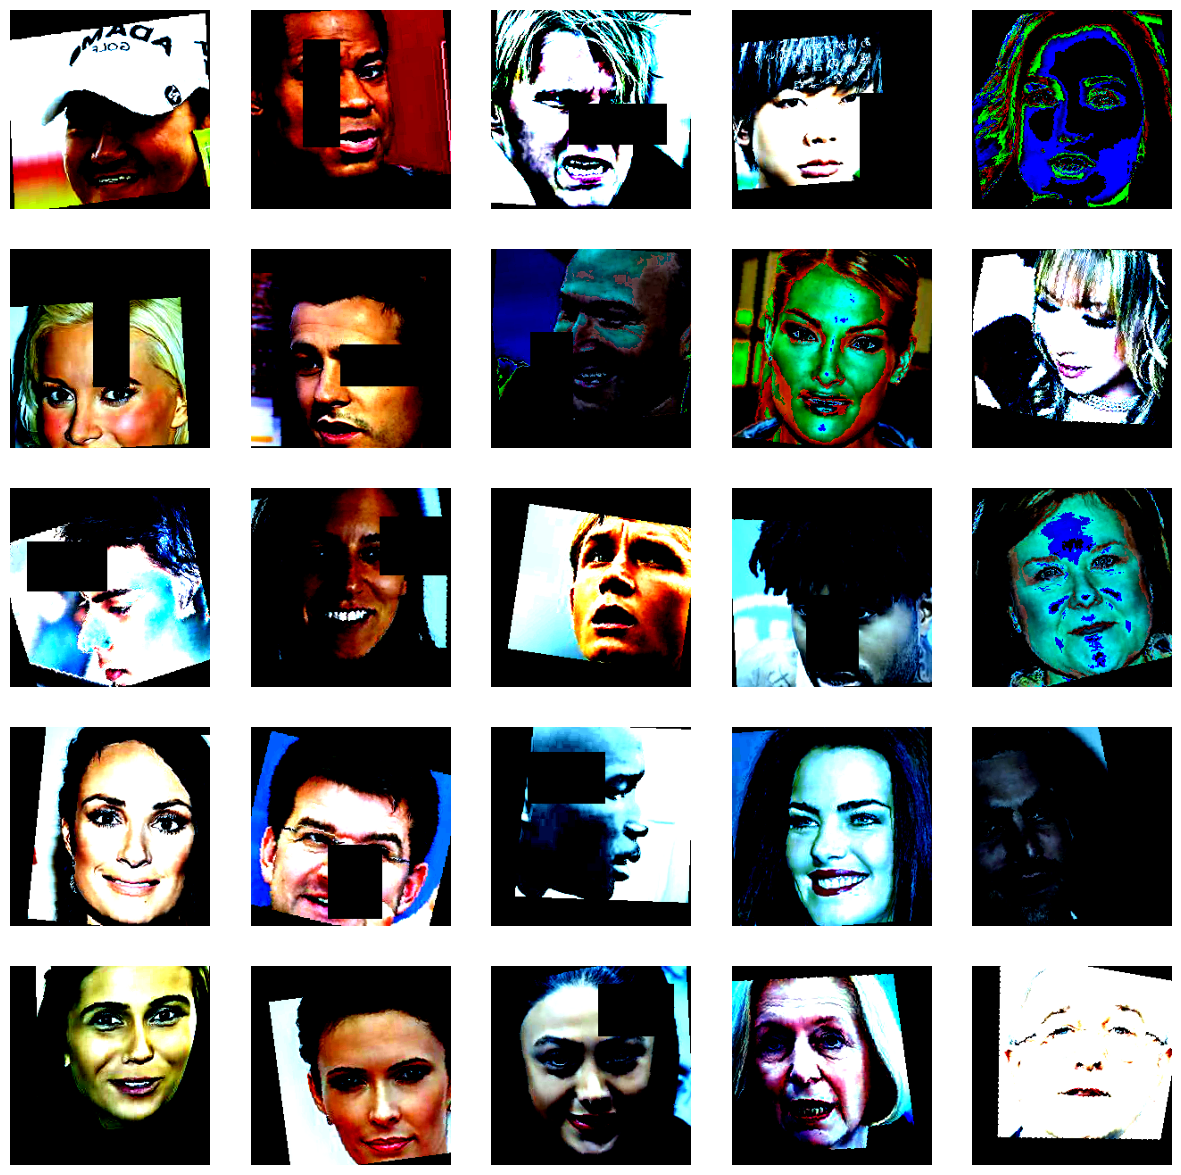

In [20]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'], 
    shuffle     = True,
)

for data in dtl:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [ ]:
# class ConvNetBlock(nn.Module):
#   def __init__(self, dim, drop_rate):
#     super().__init__()
#     self.conv1 = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups = dim)
#     self.norm = nn.BatchNorm2d(dim)
#     self.conv2 = nn.Conv2d(dim, 4*dim, kernel_size=1)
#     self.act = nn.GELU()
#     self.conv3 = nn.Conv2d(4*dim, dim, kernel_size=1)
#     self.drop_path = torchvision.ops.StochasticDepth(p = drop_rate, mode='row')
    
#   def forward(self, x):
#     input = x
#     x = self.conv1(x)
#     x = self.norm(x)
#     x = self.conv2(x)
#     x = self.act(x)
#     x = self.conv3(x)
#     x = input + self.drop_path(x)
#     return x


In [21]:
class Network(torch.nn.Module):
  def __init__(self, dim, drop_rate):
    super(Network, self).__init__()
    self.drop_path = torch.nn.Sequential(
        torchvision.ops.StochasticDepth(p=drop_rate, mode='row')
    )
    self.convolute1 = torch.nn.Conv2d(dim, dim, kernel_size = 7, padding = 3, groups = dim)
    self.convolute2 = torch.nn.Conv2d(dim, dim * 4, kernel_size = 1)
    self.convolute3 = torch.nn.Conv2d(dim * 4, dim, kernel_size=1)
    self.normalize = torch.nn.BatchNorm2d(dim)
    self.activate = torch.nn.GELU()

  def forward(self, x):
    identity = x
    x = self.convolute1(x)
    x = self.normalize(x)
    x = self.convolute2(x)
    x = self.activate(x)
    x = self.convolute3(x)
    x = self.drop_path(x)
    x += identity

    return x

In [ ]:
# class ConvNeXt(nn.Module):
#     def __init__(self, dims = [96,192,384,768], depths = [3,3,9,3], num_classes=7000):
#         super().__init__()
#         dp_rates = [x.item() for x in torch.linspace(0, 0.1, sum(depths))]
#         self.layers = nn.Sequential(
#             nn.Conv2d(3, dims[0], kernel_size=4, stride = 4),
#             nn.BatchNorm2d(dims[0]),
#             *[ConvNetBlock(dims[0], drop_rate = dp_rates[0+i]) for i in range(depths[0])],

#             nn.BatchNorm2d(dims[0]),
#             nn.Conv2d(dims[0], dims[1], kernel_size=2, stride = 2),
#             *[ConvNetBlock(dims[1], drop_rate = dp_rates[3+i]) for i in range(depths[1])],

#             nn.BatchNorm2d(dims[1]),
#             nn.Conv2d(dims[1], dims[2], kernel_size=2, stride = 2),
#             *[ConvNetBlock(dims[2], drop_rate = dp_rates[6+i]) for i in range(depths[2])],

#             nn.BatchNorm2d(dims[2]),
#             nn.Conv2d(dims[2], dims[3], kernel_size=2, stride = 2),
#             *[ConvNetBlock(dims[3], drop_rate = dp_rates[15+i]) for i in range(depths[3])]
#         )

#         self.norm = nn.BatchNorm2d(dims[-1])
#         self.classifier = nn.Linear(dims[-1], num_classes)
#         self.aag = nn.AdaptiveAvgPool2d((1,1))
    
#     def forward(self, x, return_feats=False):
#       x = self.layers(x)
#       x = self.aag(x)
#       x = x.reshape(-1, 768)
#       if return_feats == True:
#         return x
#       else:
#         x = self.classifier(x)
#         return x
  

In [22]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes = 7000, depths = [3, 3, 9, 3], dims = [96, 192, 384, 768]):
        super().__init__()
        # drop_rates = [x.item() for x in torch.linspace(0, 0.1, sum(depths))]
        drop_rate_vals = torch.linspace(0, 0.1, 18)
        drop_rates = []
        for val in drop_rate_vals:
          drop_rates.append(val.item())

        self.layers = torch.nn.Sequential(
          torch.nn.Conv2d(3, dims[0], kernel_size=4, stride=4),
          torch.nn.BatchNorm2d(dims[0]),
          Network(dims[0], drop_rate=drop_rates[0]),
          Network(dims[0], drop_rate=drop_rates[1]),
          Network(dims[0], drop_rate=drop_rates[2]),

          torch.nn.BatchNorm2d(dims[0]),
          torch.nn.Conv2d(dims[0], dims[1], kernel_size=2, stride=2),
          Network(dims[1], drop_rate=drop_rates[3]),
          Network(dims[1], drop_rate=drop_rates[4]),
          Network(dims[1], drop_rate=drop_rates[5]),

          torch.nn.BatchNorm2d(dims[1]),
          torch.nn.Conv2d(dims[1], dims[2], kernel_size=2, stride=2),
          Network(dims[2], drop_rate=drop_rates[6]),
          Network(dims[2], drop_rate=drop_rates[7]),
          Network(dims[2], drop_rate=drop_rates[8]),
          Network(dims[2], drop_rate=drop_rates[9]),
          Network(dims[2], drop_rate=drop_rates[10]),
          Network(dims[2], drop_rate=drop_rates[11]),
          Network(dims[2], drop_rate=drop_rates[12]),
          Network(dims[2], drop_rate=drop_rates[13]),
          Network(dims[2], drop_rate=drop_rates[14]),

          torch.nn.BatchNorm2d(dims[2]),
          torch.nn.Conv2d(dims[2], dims[3], kernel_size=2, stride=2),
          Network(dims[3], drop_rate=drop_rates[15]),
          Network(dims[3], drop_rate=drop_rates[16]),
          Network(dims[3], drop_rate=drop_rates[17])
          )

        self.cls_layer = torch.nn.Linear(dims[-1], num_classes)
        self.AvgPool = torch.nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x, return_feats=False):
      feats = self.layers(x)
      feats = self.AvgPool(feats)
      feats = feats.reshape(-1, 768)
      out = self.cls_layer(feats)

      if return_feats == True:
        return feats
      else:
        return out

In [23]:
model = ConvNet().to(DEVICE)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       BatchNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
       BatchNorm2d-4           [-1, 96, 56, 56]             192
            Conv2d-5          [-1, 384, 56, 56]          37,248
              GELU-6          [-1, 384, 56, 56]               0
            Conv2d-7           [-1, 96, 56, 56]          36,960
   StochasticDepth-8           [-1, 96, 56, 56]               0
           Network-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           4,800
      BatchNorm2d-11           [-1, 96, 56, 56]             192
           Conv2d-12          [-1, 384, 56, 56]          37,248
             GELU-13          [-1, 384, 56, 56]               0
           Conv2d-14           [-1, 96,

# Setup everything for training

In [24]:
# TODO: What loss do you need for a multi class classification problem?
criterion =  torch.nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])

# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100


# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

# Let's train!

In [25]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            # outputs = model(images, labels)
            outputs = model(images)
            loss    = criterion(outputs, labels)
        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # with warmup_scheduler.dampening():
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 


        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [26]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            # outputs = model(images, labels)
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [27]:
torch.cuda.empty_cache()
gc.collect() # These commands help you when you face CUDA OOM error

64696

# Wandb

In [ ]:
wandb.login(key="06c8f81427188d28de31ac7bfe0ddeadd005abc3") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "submission-15, ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: jiayang2 (jgao). Use `wandb login --relogin` to force relogin


# Experiments

In [ ]:
model.load_state_dict(torch.load("/content/model4"))

<All keys matched successfully>

In [ ]:
import gc
gc.collect()

1594

In [ ]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)

    # wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
    #            'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc
      # wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
# run.finish()


Epoch 1/100: 
Train Acc 0.0399%	 Train Loss 8.7981	 Learning Rate 0.0010


Val Acc 0.1415%	 Val Loss 8.6088
Saving model



Epoch 2/100: 
Train Acc 0.3956%	 Train Loss 8.2513	 Learning Rate 0.0010


Val Acc 1.4323%	 Val Loss 7.6133
Saving model



Epoch 3/100: 
Train Acc 2.7743%	 Train Loss 7.3568	 Learning Rate 0.0010


Val Acc 7.8635%	 Val Loss 6.5962
Saving model



Epoch 4/100: 
Train Acc 10.4057%	 Train Loss 6.3728	 Learning Rate 0.0010


Val Acc 21.3513%	 Val Loss 5.5184
Saving model



Epoch 5/100: 
Train Acc 23.8117%	 Train Loss 5.3984	 Learning Rate 0.0010


Val Acc 35.3487%	 Val Loss 4.7693
Saving model



Epoch 6/100: 
Train Acc 37.6654%	 Train Loss 4.6024	 Learning Rate 0.0010


Val Acc 46.8835%	 Val Loss 4.1465
Saving model



Epoch 7/100: 
Train Acc 49.2929%	 Train Loss 4.0072	 Learning Rate 0.0010


Val Acc 54.7696%	 Val Loss 3.7900
Saving model



Epoch 8/100: 
Train Acc 58.5025%	 Train Loss 3.5550	 Learning Rate 0.0010


Val Acc 61.2517%	 Val Loss 3.4887
Saving model



Epoch 9/100: 
Train Acc 65.2893%	 Train Loss 3.2304	 Learning Rate 0.0010


Val Acc 62.9472%	 Val Loss 3.3784
Saving model



Epoch 10/100: 
Train Acc 70.2947%	 Train Loss 2.9783	 Learning Rate 0.0010


Val Acc 66.0637%	 Val Loss 3.2421
Saving model



Epoch 11/100: 
Train Acc 74.6379%	 Train Loss 2.7680	 Learning Rate 0.0010


Val Acc 68.4896%	 Val Loss 3.1421
Saving model



Epoch 12/100: 
Train Acc 78.2540%	 Train Loss 2.5925	 Learning Rate 0.0010


Val Acc 70.5531%	 Val Loss 3.0470
Saving model



Epoch 13/100: 
Train Acc 81.3633%	 Train Loss 2.4416	 Learning Rate 0.0010


Val Acc 71.4023%	 Val Loss 3.0109
Saving model



Epoch 14/100: 
Train Acc 84.1041%	 Train Loss 2.3126	 Learning Rate 0.0010


Val Acc 72.6421%	 Val Loss 2.9614
Saving model



Epoch 15/100: 
Train Acc 86.1977%	 Train Loss 2.2123	 Learning Rate 0.0010


Val Acc 72.5204%	 Val Loss 2.9757



Epoch 16/100: 
Train Acc 88.2114%	 Train Loss 2.1206	 Learning Rate 0.0010


Val Acc 74.3546%	 Val Loss 2.8898
Saving model



Epoch 17/100: 
Train Acc 89.9578%	 Train Loss 2.0421	 Learning Rate 0.0010


Val Acc 73.7092%	 Val Loss 2.9235



Epoch 18/100: 
Train Acc 91.1240%	 Train Loss 1.9847	 Learning Rate 0.0010


Val Acc 74.5499%	 Val Loss 2.8888
Saving model



Epoch 19/100: 
Train Acc 92.0642%	 Train Loss 1.9422	 Learning Rate 0.0010


Val Acc 75.6680%	 Val Loss 2.8281
Saving model



Epoch 20/100: 
Train Acc 93.0243%	 Train Loss 1.8932	 Learning Rate 0.0010


Val Acc 75.8294%	 Val Loss 2.8457
Saving model



Epoch 21/100: 
Train Acc 93.5832%	 Train Loss 1.8606	 Learning Rate 0.0010


Val Acc 76.4380%	 Val Loss 2.8252
Saving model



Epoch 22/100: 
Train Acc 94.0309%	 Train Loss 1.8389	 Learning Rate 0.0010


Val Acc 76.4408%	 Val Loss 2.8047
Saving model



Epoch 23/100: 
Train Acc 94.5683%	 Train Loss 1.8074	 Learning Rate 0.0010


Val Acc 76.5059%	 Val Loss 2.7900
Saving model



Epoch 24/100: 
Train Acc 95.1208%	 Train Loss 1.7794	 Learning Rate 0.0010


Val Acc 77.2305%	 Val Loss 2.7674
Saving model



Epoch 25/100: 
Train Acc 95.4479%	 Train Loss 1.7613	 Learning Rate 0.0010


Val Acc 77.3834%	 Val Loss 2.7418
Saving model



Epoch 26/100: 
Train Acc 95.5876%	 Train Loss 1.7449	 Learning Rate 0.0010


Val Acc 77.8731%	 Val Loss 2.7200
Saving model



Epoch 27/100: 
Train Acc 95.9312%	 Train Loss 1.7309	 Learning Rate 0.0010


Val Acc 77.7599%	 Val Loss 2.7391



Epoch 28/100: 
Train Acc 96.1836%	 Train Loss 1.7118	 Learning Rate 0.0010


Val Acc 77.7542%	 Val Loss 2.7582



Epoch 29/100: 
Train Acc 96.4644%	 Train Loss 1.6966	 Learning Rate 0.0010


Val Acc 78.1703%	 Val Loss 2.7353
Saving model



Epoch 30/100: 
Train Acc 96.5058%	 Train Loss 1.6861	 Learning Rate 0.0010


Val Acc 77.9891%	 Val Loss 2.7548
Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.



Epoch 31/100: 
Train Acc 98.0333%	 Train Loss 1.5954	 Learning Rate 0.0001


Val Acc 81.1623%	 Val Loss 2.6515
Saving model



Epoch 32/100: 
Train Acc 98.5380%	 Train Loss 1.5523	 Learning Rate 0.0001


Val Acc 81.6774%	 Val Loss 2.6280
Saving model



Epoch 33/100: 
Train Acc 98.6877%	 Train Loss 1.5350	 Learning Rate 0.0001


Val Acc 82.1048%	 Val Loss 2.6225
Saving model



Epoch 34/100: 
Train Acc 98.8174%	 Train Loss 1.5205	 Learning Rate 0.0001


Val Acc 82.1586%	 Val Loss 2.6203
Saving model



Epoch 35/100: 
Train Acc 98.8445%	 Train Loss 1.5126	 Learning Rate 0.0001


Val Acc 82.2945%	 Val Loss 2.6157
Saving model



Epoch 36/100: 
Train Acc 98.9457%	 Train Loss 1.5038	 Learning Rate 0.0001


Val Acc 82.4502%	 Val Loss 2.6202
Saving model



Epoch 37/100: 
Train Acc 98.9757%	 Train Loss 1.4980	 Learning Rate 0.0001


Val Acc 82.6059%	 Val Loss 2.6264
Saving model



Epoch 38/100: 
Train Acc 99.0227%	 Train Loss 1.4915	 Learning Rate 0.0001


Val Acc 82.5266%	 Val Loss 2.6225



Epoch 39/100: 
Train Acc 99.0448%	 Train Loss 1.4857	 Learning Rate 0.0001


Val Acc 82.7106%	 Val Loss 2.6205
Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.
Saving model



Epoch 40/100: 
Train Acc 99.1018%	 Train Loss 1.4784	 Learning Rate 0.0000


Val Acc 82.8408%	 Val Loss 2.6318
Saving model



Epoch 41/100: 
Train Acc 99.1753%	 Train Loss 1.4741	 Learning Rate 0.0000


Val Acc 82.8635%	 Val Loss 2.6317
Saving model



Epoch 42/100: 
Train Acc 99.1503%	 Train Loss 1.4740	 Learning Rate 0.0000


Val Acc 82.9512%	 Val Loss 2.6232
Saving model



Epoch 43/100: 
Train Acc 99.1724%	 Train Loss 1.4733	 Learning Rate 0.0000


Val Acc 82.9172%	 Val Loss 2.6278
Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.



Epoch 44/100: 
Train Acc 99.1681%	 Train Loss 1.4724	 Learning Rate 0.0000


Val Acc 82.9314%	 Val Loss 2.6308



Epoch 45/100: 
Train Acc 99.1247%	 Train Loss 1.4746	 Learning Rate 0.0000


Val Acc 82.9682%	 Val Loss 2.6294
Saving model



Epoch 46/100: 
Train Acc 99.1845%	 Train Loss 1.4720	 Learning Rate 0.0000


Val Acc 82.9229%	 Val Loss 2.6279



Epoch 47/100: 
Train Acc 99.1482%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9569%	 Val Loss 2.6324
Epoch 00047: reducing learning rate of group 0 to 1.0000e-07.



Epoch 48/100: 
Train Acc 99.1510%	 Train Loss 1.4732	 Learning Rate 0.0000


Val Acc 82.9229%	 Val Loss 2.6296



Epoch 49/100: 
Train Acc 99.1289%	 Train Loss 1.4730	 Learning Rate 0.0000


Val Acc 82.9710%	 Val Loss 2.6300
Saving model



Epoch 50/100: 
Train Acc 99.1382%	 Train Loss 1.4724	 Learning Rate 0.0000


Val Acc 82.9710%	 Val Loss 2.6285
Saving model



Epoch 51/100: 
Train Acc 99.1247%	 Train Loss 1.4734	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6326
Epoch 00051: reducing learning rate of group 0 to 1.0000e-08.



Epoch 52/100: 
Train Acc 99.1674%	 Train Loss 1.4718	 Learning Rate 0.0000


Val Acc 82.9540%	 Val Loss 2.6266



Epoch 53/100: 
Train Acc 99.1503%	 Train Loss 1.4714	 Learning Rate 0.0000


Val Acc 82.9370%	 Val Loss 2.6319



Epoch 54/100: 
Train Acc 99.1717%	 Train Loss 1.4722	 Learning Rate 0.0000


Val Acc 82.9314%	 Val Loss 2.6304



Epoch 55/100: 
Train Acc 99.1681%	 Train Loss 1.4723	 Learning Rate 0.0000


Val Acc 82.9682%	 Val Loss 2.6343



Epoch 56/100: 
Train Acc 99.1831%	 Train Loss 1.4716	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6309



Epoch 57/100: 
Train Acc 99.1489%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6313



Epoch 58/100: 
Train Acc 99.1532%	 Train Loss 1.4723	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6333



Epoch 59/100: 
Train Acc 99.1610%	 Train Loss 1.4730	 Learning Rate 0.0000


Val Acc 82.9484%	 Val Loss 2.6328



Epoch 60/100: 
Train Acc 99.1867%	 Train Loss 1.4711	 Learning Rate 0.0000


Val Acc 82.9116%	 Val Loss 2.6336



Epoch 61/100: 
Train Acc 99.1795%	 Train Loss 1.4718	 Learning Rate 0.0000


Val Acc 82.9484%	 Val Loss 2.6313



Epoch 62/100: 
Train Acc 99.1810%	 Train Loss 1.4723	 Learning Rate 0.0000


Val Acc 82.9512%	 Val Loss 2.6306



Epoch 63/100: 
Train Acc 99.1646%	 Train Loss 1.4730	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6290



Epoch 64/100: 
Train Acc 99.1639%	 Train Loss 1.4721	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6281



Epoch 65/100: 
Train Acc 99.1781%	 Train Loss 1.4717	 Learning Rate 0.0000


Val Acc 82.9767%	 Val Loss 2.6273
Saving model



Epoch 66/100: 
Train Acc 99.1781%	 Train Loss 1.4728	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6321



Epoch 67/100: 
Train Acc 99.1738%	 Train Loss 1.4726	 Learning Rate 0.0000


Val Acc 82.9880%	 Val Loss 2.6290
Saving model



Epoch 68/100: 
Train Acc 99.1924%	 Train Loss 1.4721	 Learning Rate 0.0000


Val Acc 82.9540%	 Val Loss 2.6326



Epoch 69/100: 
Train Acc 99.1639%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9257%	 Val Loss 2.6302



Epoch 70/100: 
Train Acc 99.1582%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9738%	 Val Loss 2.6310



Epoch 71/100: 
Train Acc 99.1639%	 Train Loss 1.4723	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6322



Epoch 72/100: 
Train Acc 99.1197%	 Train Loss 1.4734	 Learning Rate 0.0000


Val Acc 82.9682%	 Val Loss 2.6286



Epoch 73/100: 
Train Acc 99.1175%	 Train Loss 1.4739	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6344



Epoch 74/100: 
Train Acc 99.1774%	 Train Loss 1.4720	 Learning Rate 0.0000


Val Acc 82.9654%	 Val Loss 2.6253



Epoch 75/100: 
Train Acc 99.1795%	 Train Loss 1.4724	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6329



Epoch 76/100: 
Train Acc 99.1810%	 Train Loss 1.4725	 Learning Rate 0.0000


Val Acc 82.9710%	 Val Loss 2.6243



Epoch 77/100: 
Train Acc 99.1482%	 Train Loss 1.4720	 Learning Rate 0.0000


Val Acc 82.9484%	 Val Loss 2.6308



Epoch 78/100: 
Train Acc 99.1375%	 Train Loss 1.4724	 Learning Rate 0.0000


Val Acc 82.9710%	 Val Loss 2.6267



Epoch 79/100: 
Train Acc 99.1767%	 Train Loss 1.4727	 Learning Rate 0.0000


Val Acc 82.9257%	 Val Loss 2.6323



Epoch 80/100: 
Train Acc 99.1681%	 Train Loss 1.4720	 Learning Rate 0.0000


Val Acc 82.9484%	 Val Loss 2.6292



Epoch 81/100: 
Train Acc 99.1646%	 Train Loss 1.4715	 Learning Rate 0.0000


Val Acc 82.9512%	 Val Loss 2.6262



Epoch 82/100: 
Train Acc 99.1788%	 Train Loss 1.4729	 Learning Rate 0.0000


Val Acc 82.9399%	 Val Loss 2.6320



Epoch 83/100: 
Train Acc 99.1225%	 Train Loss 1.4738	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6340



Epoch 84/100: 
Train Acc 99.1974%	 Train Loss 1.4721	 Learning Rate 0.0000


Val Acc 82.9654%	 Val Loss 2.6326



Epoch 85/100: 
Train Acc 99.1967%	 Train Loss 1.4705	 Learning Rate 0.0000


Val Acc 82.9455%	 Val Loss 2.6298



Epoch 86/100: 
Train Acc 99.1368%	 Train Loss 1.4730	 Learning Rate 0.0000


Val Acc 82.9852%	 Val Loss 2.6318



Epoch 87/100: 
Train Acc 99.1603%	 Train Loss 1.4722	 Learning Rate 0.0000


Val Acc 82.9795%	 Val Loss 2.6271



Epoch 88/100: 
Train Acc 99.1553%	 Train Loss 1.4730	 Learning Rate 0.0000


Val Acc 82.9682%	 Val Loss 2.6340



Epoch 89/100: 
Train Acc 99.1225%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6334



Epoch 90/100: 
Train Acc 99.1689%	 Train Loss 1.4726	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6291



Epoch 91/100: 
Train Acc 99.1660%	 Train Loss 1.4709	 Learning Rate 0.0000


Val Acc 82.9342%	 Val Loss 2.6322



Epoch 92/100: 
Train Acc 99.1952%	 Train Loss 1.4723	 Learning Rate 0.0000


Val Acc 82.9682%	 Val Loss 2.6324



Epoch 93/100: 
Train Acc 99.1681%	 Train Loss 1.4722	 Learning Rate 0.0000


Val Acc 82.9540%	 Val Loss 2.6283



Epoch 94/100: 
Train Acc 99.1674%	 Train Loss 1.4731	 Learning Rate 0.0000


Val Acc 82.9427%	 Val Loss 2.6336



Epoch 95/100: 
Train Acc 99.1803%	 Train Loss 1.4733	 Learning Rate 0.0000


Val Acc 82.9569%	 Val Loss 2.6336



Epoch 96/100: 
Train Acc 99.1503%	 Train Loss 1.4721	 Learning Rate 0.0000


Val Acc 82.9342%	 Val Loss 2.6313



Epoch 97/100: 
Train Acc 99.1831%	 Train Loss 1.4718	 Learning Rate 0.0000


Val Acc 82.9852%	 Val Loss 2.6270



Epoch 98/100: 
Train Acc 99.1632%	 Train Loss 1.4734	 Learning Rate 0.0000


Val Acc 82.9597%	 Val Loss 2.6272



Epoch 99/100: 
Train Acc 99.1653%	 Train Loss 1.4725	 Learning Rate 0.0000


Val Acc 82.9484%	 Val Loss 2.6268



Epoch 100/100: 
Train Acc 99.1667%	 Train Loss 1.4718	 Learning Rate 0.0000


Val Acc 82.9823%	 Val Loss 2.6311


In [ ]:
torch.save(model.state_dict(), "model5")

In [ ]:
run.finish() 

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
len(test_results)

35000

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_slack_submission4.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification-slackkaggle -f classification_slack_submission4.csv -m "Message"

100% 507k/507k [00:02<00:00, 213kB/s]
Successfully submitted to Face Classification (Slack)

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 


100%|██████████| 360/360 [00:00<00:00, 10497.06it/s]

100%|██████████| 720/720 [00:00<00:00, 10459.10it/s]

100%|██████████| 960/960 [00:00<00:00, 13361.25it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    print(similarity_values.shape)
    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    print(similarity_values.max(0))
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

torch.Size([960, 360])
torch.return_types.max(
values=tensor([0.2778, 0.4355, 0.2987, 0.4978, 0.3387, 0.2563, 0.5221, 0.3737, 0.4556,
        0.3883, 0.2790, 0.2679, 0.3353, 0.3892, 0.3523, 0.5204, 0.3382, 0.3791,
        0.4494, 0.4314, 0.3628, 0.6163, 0.4687, 0.4952, 0.5176, 0.4704, 0.3226,
        0.3392, 0.3471, 0.4684, 0.4573, 0.4875, 0.2893, 0.3930, 0.3926, 0.3598,
        0.4176, 0.4604, 0.4087, 0.2691, 0.5524, 0.2844, 0.4258, 0.3948, 0.3228,
        0.3457, 0.3086, 0.3574, 0.5806, 0.4100, 0.4680, 0.4729, 0.4538, 0.4532,
        0.3789, 0.3791, 0.4774, 0.5023, 0.4127, 0.3870, 0.3149, 0.4334, 0.2830,
        0.5258, 0.3271, 0.5962, 0.3654, 0.3486, 0.3111, 0.3098, 0.3870, 0.3814,
        0.3283, 0.4308, 0.6981, 0.4271, 0.3368, 0.3694, 0.4562, 0.4025, 0.4387,
        0.5078, 0.3654, 0.3701, 0.4577, 0.3800, 0.6092, 0.4290, 0.2648, 0.5884,
        0.3414, 0.3447, 0.4210, 0.3577, 0.4956, 0.3227, 0.6258, 0.4073, 0.4678,
        0.5195, 0.4576, 0.3736, 0.4633, 0.4521, 0.3372, 0.5591, 0.

torch.Size([960, 720])
torch.return_types.max(
values=tensor([0.3438, 0.2584, 0.3543, 0.7086, 0.3860, 0.2984, 0.3844, 0.2870, 0.2452,
        0.4361, 0.4284, 0.6148, 0.3929, 0.4210, 0.4767, 0.3127, 0.6717, 0.3659,
        0.4035, 0.4185, 0.4335, 0.2988, 0.3406, 0.4234, 0.3824, 0.3365, 0.3650,
        0.7921, 0.4829, 0.5282, 0.3098, 0.6421, 0.3251, 0.2658, 0.4038, 0.3262,
        0.6048, 0.4664, 0.3828, 0.3967, 0.3268, 0.3552, 0.2700, 0.5250, 0.5109,
        0.3425, 0.4700, 0.3320, 0.2366, 0.5080, 0.3925, 0.4656, 0.3625, 0.4360,
        0.2844, 0.4290, 0.3445, 0.4209, 0.3598, 0.4342, 0.3729, 0.4720, 0.4896,
        0.3691, 0.5208, 0.4827, 0.3609, 0.4025, 0.3558, 0.7196, 0.4184, 0.2739,
        0.6438, 0.3384, 0.5126, 0.3275, 0.3806, 0.5753, 0.4129, 0.3825, 0.5466,
        0.5730, 0.3153, 0.3854, 0.4472, 0.2977, 0.3262, 0.3908, 0.3838, 0.3275,
        0.2867, 0.5009, 0.2953, 0.5061, 0.2657, 0.4772, 0.3969, 0.3195, 0.5154,
        0.4153, 0.3683, 0.4360, 0.3426, 0.2664, 0.3294, 0.5010, 0.

In [ ]:
# add your finetune/retrain code here

In [ ]:
len(pred_id_strings)

720

## Generate csv to submit to Kaggle

In [ ]:
with open("verification_slack_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification-slack -f verification_slack_submission.csv -m "Message"

100% 8.34k/8.34k [00:02<00:00, 3.32kB/s]
Successfully submitted to Face Verification (Slack)